<a href="https://colab.research.google.com/github/SJkzk/Hypo_Adverse_ML/blob/main/newen_hypotension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sklearn
import pandas as pd
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt
# import vitaldb

df_cases = pd.read_csv('https://api.vitaldb.net/cases') # 0~6387 entries, clinical info
df_ids = pd.read_csv('https://api.vitaldb.net/trks') # ids of tracks 
# df_ids.describe()

ids = range(1,200)    #1,12 is strage ,55,58 ;;;;;;     109 not accessible



SyntaxError: ignored

In [ ]:
caseids_ART= [] #id with error
caseids_art_error= "" #id with error
for theid in ids:
  try:
    ids = df_ids[(df_ids['tname'] == "Solar8000/ART_MBP") & (df_ids['caseid'] == theid)]['tid'].values[0]
    # get the id of this case to search for its tracks infos.
    df_MAP_1 = pd.read_csv("https://api.vitaldb.net/"+ids)
    # web for specific waves - CASE + TYPE
    caseids_ART.append(theid) # NOTEDOWN cases with error in ART
  except:
    caseids_art_error = caseids_art_error +" "+str(theid) # NOTEDOWN cases with error in ART
    pass
  continue
# print(caseids_art_error+" don't have ART")

# print(caseids_ART)
# use this for following iteratives

**step1:** Create Function to clear the hypotension




In [ ]:
# TEST PART
# !pip install vitaldb

# df_ids[df_ids['caseid']==2]
# df_MAP_1.head()

# hidden: the filter settings, for neorit

In [ ]:
def _signal_filter_butterworth(signal, sampling_rate=1000, lowcut=None, highcut=None, order=5):
    """Filter a signal using IIR Butterworth SOS method."""
    freqs, filter_type = _signal_filter_sanitize(
        lowcut=lowcut, highcut=highcut, sampling_rate=sampling_rate
    )

    sos = sp.butter(order, freqs, btype=filter_type, output="sos", fs=sampling_rate)
    filtered = sp.sosfiltfilt(sos, signal)
    return filtered

def _signal_filter_sanitize(lowcut=None, highcut=None, sampling_rate=1000, normalize=False):

    # Sanity checks
    if isinstance(highcut, int):
        if sampling_rate <= 2 * highcut:
            warn(
                "The sampling rate is too low. Sampling rate"
                " must exceed the Nyquist rate to avoid aliasing problem."
                f" In this analysis, the sampling rate has to be higher than {2 * highcut} Hz",
                category=NeuroKitWarning,
            )

    # Replace 0 by none
    if lowcut is not None and lowcut == 0:
        lowcut = None
    if highcut is not None and highcut == 0:
        highcut = None

    # Format
    if lowcut is not None and highcut is not None:
        if lowcut > highcut:
            filter_type = "bandstop"
        else:
            filter_type = "bandpass"
        freqs = [lowcut, highcut]
    elif lowcut is not None:
        freqs = [lowcut]
        filter_type = "highpass"
    elif highcut is not None:
        freqs = [highcut]
        filter_type = "lowpass"

    # Normalize frequency to Nyquist Frequency (Fs/2).
    # However, no need to normalize if `fs` argument is provided to the scipy filter
    if normalize is True:
        freqs = np.array(freqs) / (sampling_rate / 2)

    return freqs, filter_type

In [ ]:
def Hypo_Clear(theid):
  ids = df_ids[(df_ids['tname'] == "Solar8000/ART_MBP") & (df_ids['caseid'] == theid)]['tid'].values[0]
  # get the id of this case to search for its tracks infos.

  df_MAP_1 = pd.read_csv("https://api.vitaldb.net/"+ids)
  # web for specific waves - CASE + TYPE

  # DRAW WAVEFORMS AND TIME DURATION OF ANAES
  df_cases.loc[df_cases['caseid']==theid]
  anesta = df_cases.loc[df_cases['caseid']==theid]['anestart'].values[0] # start of anesthesia
  anesend = df_cases.loc[df_cases['caseid']==theid]['aneend'].values[0]

  # plt.figure(figsize=(20,4))
  # plt.plot(df_MAP_1['Time'],df_MAP_1['Solar8000/ART_MBP'])
  # plt.axvline(anesta,color='r',linestyle='--')
  # plt.axvline(anesend,color='r',linestyle='--')
  # plt.ylim((-50,300))

  median = df_MAP_1['Solar8000/ART_MBP'].median()
  for x in df_MAP_1.index:
    if df_MAP_1.loc[x, "Solar8000/ART_MBP"] < median-40 : #****paras
      df_MAP_1.loc[x, "Solar8000/ART_MBP"] = np.nan
  df_MAP_1['Solar8000/ART_MBP'].fillna(median, inplace=True)

  sig = df_MAP_1[['Time','Solar8000/ART_MBP']]
  filtered = _signal_filter_butterworth(sig['Solar8000/ART_MBP'], sampling_rate=200, highcut=6, order=6)  #6 6

  wid_ra = [0,50]
  peaks, properties = sp.find_peaks(filtered, prominence=30, width = wid_ra) #!!!!!!***para adjust!!
  # plt.plot(df_MAP_1['Time'][peaks], filtered[peaks], "x",color='r')

  results_half = sp.peak_widths(filtered, peaks, rel_height=0.9)

  onsets = results_half[2].astype(int)
  offsets = results_half[3].astype(int)
  # plt.vlines(sig['Time'][onsets],-50,300,color='r',linestyles='dashed')
  # plt.vlines(sig['Time'][offsets],-50,300,color='b',linestyles='dashed')

  # remove with ips:
  # del range
  len_p = len(peaks)
  # sig = df_MAP_1[['Time','Solar8000/ART_MBP']]
  sig['Solar8000/ART_MBP'] = _signal_filter_butterworth(sig['Solar8000/ART_MBP'], sampling_rate=100, highcut=6, order=6)
  for i in range(len_p):
    # filtered[onsets[i]:offsets[i]] = median
    if (results_half[0][i].astype(int) > wid_ra[1]):
      onsets[i] = peaks[i]-wid_ra[1]
      offsets[i] = peaks[i]+wid_ra[1]
    sig['Solar8000/ART_MBP'][onsets[i]:offsets[i]] = np.nan

  return df_MAP_1, sig
    

#**执行台**

1.   List item
2.   List item



(-50.0, 300.0)

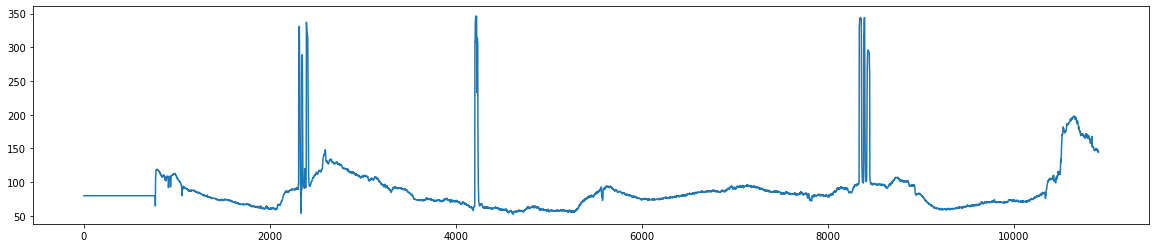

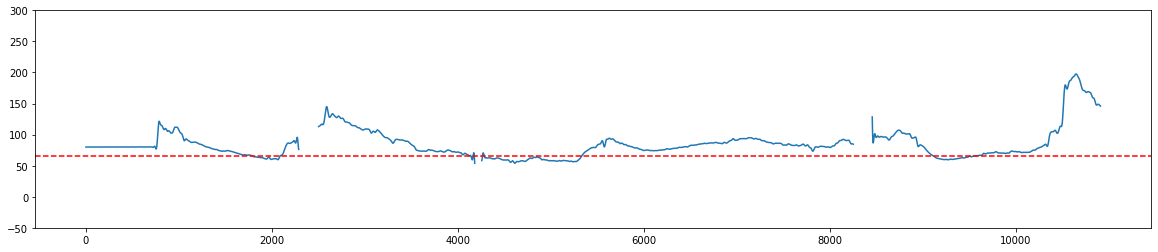

In [ ]:
ori, cleared = Hypo_Clear(1)
plt.figure(figsize=(20,4))
plt.plot(ori['Time'],ori['Solar8000/ART_MBP'])
plt.figure(figsize=(20,4))
plt.plot(cleared['Time'],cleared['Solar8000/ART_MBP'])

plt.axhline(65,color='r',linestyle='--') # draw the "hypotension bar"
plt.ylim((-50,300))

In [ ]:
cleared
N = len(cleared)
n_index = [i for i in range(0,N,20)]  # start of every segement

[0,
 20,
 40,
 60,
 80,
 100,
 120,
 140,
 160,
 180,
 200,
 220,
 240,
 260,
 280,
 300,
 320,
 340,
 360,
 380,
 400,
 420,
 440,
 460,
 480,
 500,
 520,
 540,
 560,
 580,
 600,
 620,
 640,
 660,
 680,
 700,
 720,
 740,
 760,
 780,
 800,
 820,
 840,
 860,
 880,
 900,
 920,
 940,
 960,
 980,
 1000,
 1020,
 1040,
 1060,
 1080,
 1100,
 1120,
 1140,
 1160,
 1180,
 1200,
 1220,
 1240,
 1260,
 1280,
 1300,
 1320,
 1340,
 1360,
 1380,
 1400,
 1420,
 1440,
 1460,
 1480,
 1500,
 1520,
 1540,
 1560,
 1580,
 1600,
 1620,
 1640,
 1660,
 1680,
 1700,
 1720,
 1740,
 1760,
 1780,
 1800,
 1820,
 1840,
 1860,
 1880,
 1900,
 1920,
 1940,
 1960,
 1980,
 2000,
 2020,
 2040,
 2060,
 2080,
 2100,
 2120,
 2140,
 2160,
 2180,
 2200,
 2220,
 2240,
 2260,
 2280,
 2300,
 2320,
 2340,
 2360,
 2380,
 2400,
 2420,
 2440,
 2460,
 2480,
 2500,
 2520,
 2540,
 2560,
 2580,
 2600,
 2620,
 2640,
 2660,
 2680,
 2700,
 2720,
 2740,
 2760,
 2780,
 2800,
 2820,
 2840,
 2860,
 2880,
 2900,
 2920,
 2940,
 2960,
 2980,
 3000,